In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

In [26]:
# Load the CSV file
file_train_path = './CETC331/Training_CETC331.csv'
file_test_path = './CETC331/Testing_CETC331.csv'

test_data = pd.read_csv(file_test_path)
train_data = pd.read_csv(file_train_path)

training_summary = train_data.describe()
testing_summary = test_data.describe()

train_data.head(), test_data.head(), training_summary.iloc[:, :10], testing_summary.iloc[:, :10]

(   MAC1  MAC2  MAC3  MAC4  MAC5  MAC6  MAC7  MAC8  MAC9  MAC10  ...  MAC51  \
 0   -44   -48   -71   -85   -92   100   100   100   -88    100  ...    100   
 1   -37   -50   -72   -85   -93   100   -93   100   -86    100  ...    100   
 2   -41   -51   -68   -84   -88   100   -93   100   -84    100  ...    100   
 3   -38   -50   -67   -89   -83   -90   -92   100   -83    100  ...    100   
 4   -35   -57   -63   -87   -86   -87   100   100   -81    100  ...    100   
 
    MAC52  ECoord  NCoord  FloorID  BuildingID  SceneID  UserID  PhoneID  \
 0    100    45.0    17.5        1           1        1       4        3   
 1    100    45.5    17.5        1           1        1       4        3   
 2    100    46.0    17.5        1           1        1       4        3   
 3    100    46.5    17.5        1           1        1       4        3   
 4    100    46.9    17.5        1           1        1       4        3   
 
    SampleTimes  
 0            1  
 1            1  
 2          

In [27]:
irrelevant_features = ['ECoord', 'NCoord', 'FloorID', 'BuildingID', 'SceneID', 'UserID', 'PhoneID', 'SampleTimes']

output_variables = ['ECoord', 'NCoord']

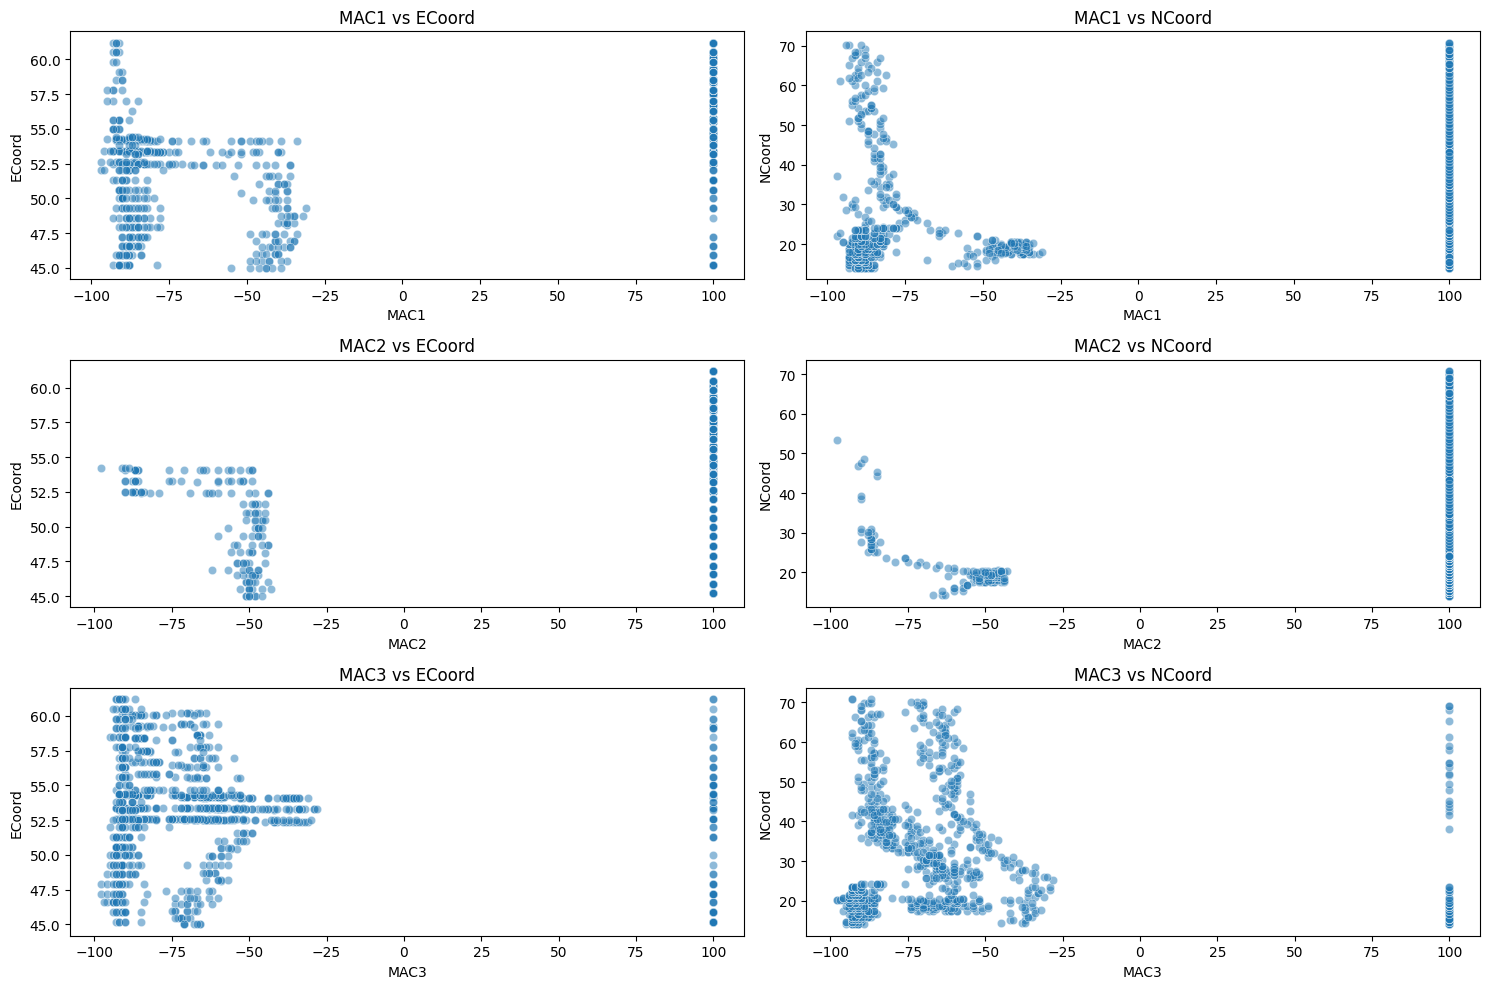

In [28]:
rssi_columns = ['MAC1', 'MAC2', 'MAC3']

# Setting up the plotting
fig, axes = plt.subplots(len(rssi_columns), len(output_variables), figsize=(15, 10))

for i, rssi_col in enumerate(rssi_columns):
    for j, output_var in enumerate(output_variables):
        # Scatter plot for each combination of RSSI value and output variable
        sns.scatterplot(x=train_data[rssi_col], y=train_data[output_var], ax=axes[i, j], alpha=0.5)
        axes[i, j].set_title(f'{rssi_col} vs {output_var}')

plt.tight_layout()
plt.show()

In [29]:
# Relevant data for training
X_train = train_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_train = train_data[output_variables]


In [30]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)

# The number of components after PCA
n_components = X_train.shape[1]

n_components

23

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# confirm scaling has been done properly
X_train.mean(), X_train.std()

(-7.60198237667305e-18, 0.9999999999999999)

In [32]:
# Preprocessing testing data similarly
X_test = test_data.drop(irrelevant_features, axis=1).replace(100, -200)
Y_test = test_data[output_variables]

# Same PCA
X_test = pca.transform(X_test)

# Apply scaler
X_test = scaler.transform(X_test) 

In [33]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Training a linear regression model for ECoord
cv_scores = cross_val_score(LinearRegression(), X_train, Y_train, cv=5, scoring='neg_mean_squared_error')

# Compute the average RMSE across the cross-validation folds
average_rmse = (-cv_scores.mean()) ** 0.5

average_rmse

6.3119420223488225

In [34]:
model = LinearRegression().fit(X_train, Y_train)

y_pred = model.predict(X_test)
predictions_df = pd.DataFrame(y_pred, columns=['Pred_ECoord', 'Pred_NCoord'])

rmse_test = root_mean_squared_error(Y_test, predictions_df)
r2_score = r2_score(Y_test, y_pred)

rmse_test, r2_score

(4.8456869002381655, 0.6319665528195446)

C:\Users\gps18.REMAINHEALTHY\AppData\Local\Temp\ipykernel_24164\2528410837.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 100)


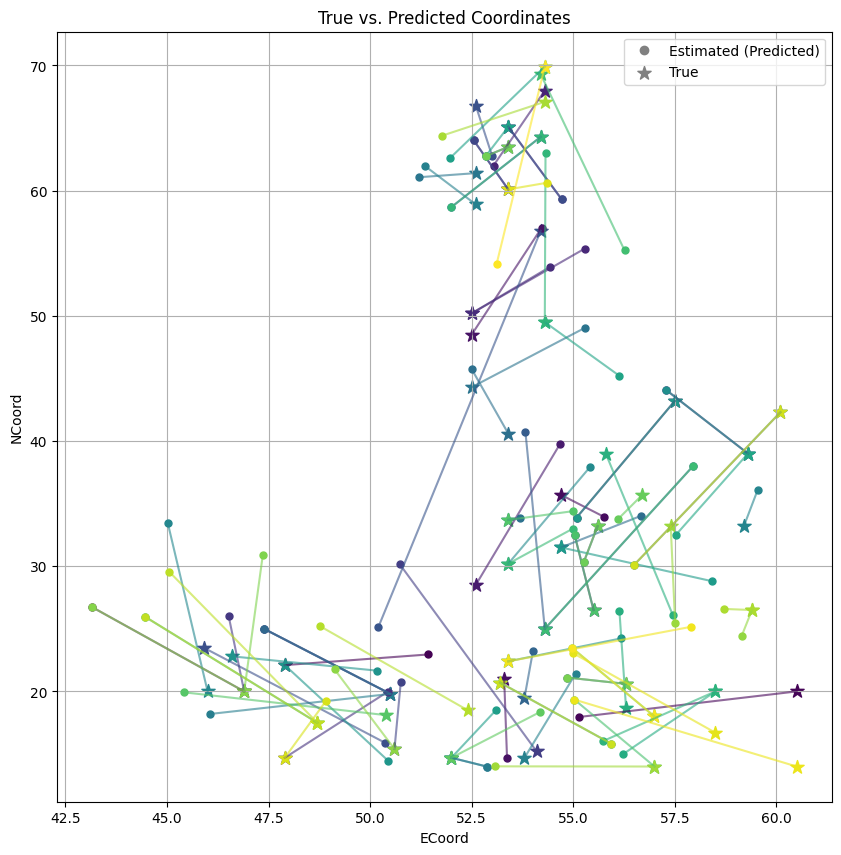

In [35]:
np.random.seed(42)  

random_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
X_test_random = X_test[random_indices]

y_pred_random = model.predict(X_test_random)

y_test_random = Y_test.loc[random_indices]

# Preparing the visualization
plt.figure(figsize=(10, 10))
cmap = plt.cm.get_cmap('viridis', 100)

for i, (true, pred) in enumerate(zip(y_test_random.values, y_pred_random)):
        color = cmap(i)
        plt.plot([true[0], pred[0]], [true[1], pred[1]], '-', alpha=0.6, color=color)
        plt.plot(pred[0], pred[1], 'o', markersize=5, color=color)
        plt.scatter(true[0], true[1], marker='*', s=100, color=color)  

plt.plot([], [], 'o', color='gray', label='Estimated (Predicted)')
plt.scatter([], [], marker='*', s=100, color='gray', label='True')

plt.legend()
plt.title('True vs. Predicted Coordinates')
plt.xlabel('ECoord')
plt.ylabel('NCoord')
plt.grid(True)
plt.show()

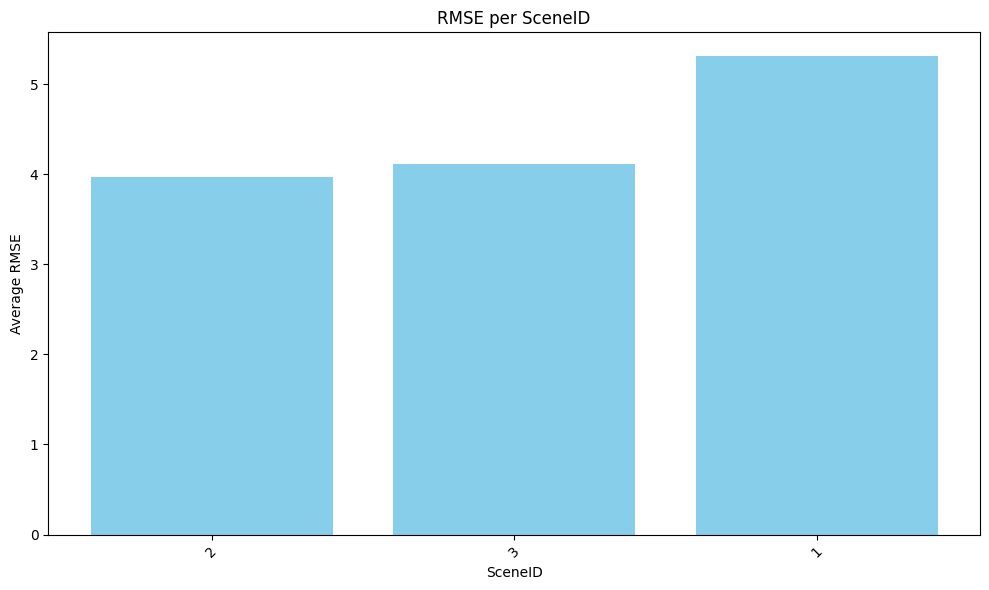

In [36]:
rmse_values = []

# Iterate over each SceneID
for scene_id in test_data['SceneID'].unique():
    # Filter the data for the current SceneID
    df_scene = test_data[test_data['SceneID'] == scene_id]
    
    X_scene = df_scene.drop(irrelevant_features, axis=1)
    y_true_scene = df_scene[['ECoord', 'NCoord']]
    
    X_scene = X_scene.replace(100, -200)

    X_scene = pca.transform(X_scene)  

    X_scene = scaler.transform(X_scene)

    y_pred_scene = model.predict(X_scene)

    rmse_ecoord = np.sqrt(mean_squared_error(y_true_scene['ECoord'], y_pred_scene[:, 0]))
    rmse_ncoord = np.sqrt(mean_squared_error(y_true_scene['NCoord'], y_pred_scene[:, 1]))
    
    rmse_avg = (rmse_ecoord + rmse_ncoord) / 2
    
    rmse_values.append((scene_id, rmse_avg))

rmse_df = pd.DataFrame(rmse_values, columns=['SceneID', 'RMSE'])

rmse_df = rmse_df.sort_values('RMSE')


plt.figure(figsize=(10, 6))
plt.bar(rmse_df['SceneID'].astype(str), rmse_df['RMSE'], color='skyblue')
plt.xlabel('SceneID')
plt.ylabel('Average RMSE')
plt.title('RMSE per SceneID')
plt.xticks(rotation=45)
plt.tight_layout()